In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
from pycocotools.coco import COCO
import re
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [2]:
with open('../mmdetection/result/retinanet_swin-l/result.bbox.json', 'r') as f:
    swin_data = json.load(f)

with open('../mmdetection/result/faster_rcnn/result.bbox.json', 'r') as f:
    rcnn_data = json.load(f)

with open('../yolov7/runs/test/yolov7_640_val2/last_predictions.json', 'r') as f:
    yolo_data = json.load(f)

In [3]:
coco = COCO('../info/test.json')

img_path_to_id = {re.sub('.jpg', '', os.path.basename(
    x['file_name'])): x['id'] for x in coco.loadImgs(coco.getImgIds())}

for i in range(len(yolo_data)):
    yolo_data[i]['image_id'] = img_path_to_id[yolo_data[i]['image_id']]
    yolo_data[i]['category_id'] += 1

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
coco_gld = COCO('../info/test.json')
coco_rst = coco_gld.loadRes('../mmdetection/result/retinanet_swin-l/result.bbox.json')
cocoEval = COCOeval(coco_gld, coco_rst, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

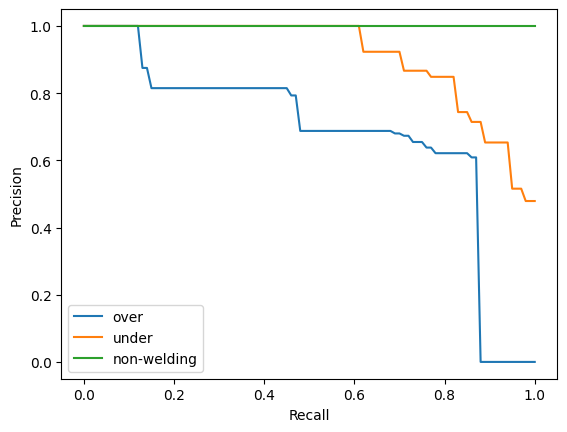

In [6]:
results = cocoEval.eval

x = np.linspace(0 ,1 ,101)
y1 = results['precision'][0,:, 0, 0 , -1]
y2 = results['precision'][0,:, 1, 0 , -1]
y3 = results['precision'][0,:, 2, 0 , -1]
plt.plot(x , y1 , label = 'over')
plt.plot(x , y2 , label = 'under')
plt.plot(x , y3 , label = 'non-welding')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [7]:
def get_conf_list(result):
    conf_list = []
    for idx in result['gtMatches'][0,:]:
        if idx == 0:
            conf_list.append(0)
        else:
            gt_idx = np.where(result['dtIds'] == idx)
            conf_list.append(float(np.array(result['dtScores'])[gt_idx]))
    return conf_list
def get_PR(coco_gt  , cocoEval , conf_score , catId):
    pred_list = []
    truth_list = []
    pred_conf_list = []
    truth_conf_list = []
    for img_id in sorted(coco_gt.getImgIds()):
        result = cocoEval.evaluateImg( imgId  = img_id , catId=catId, aRng =[0 , 100000], maxDet = 1000)
        
        if result:
            # 0 idx => IoU thrs 0.5
            pred = result['dtMatches'][0,:] 
            pred_conf = result['dtScores']

            pred_list.append(pred.tolist())
            pred_conf_list.append(pred_conf)

            truth = result['gtMatches'][0,:] 
            confidence = get_conf_list(result)

            truth_list.append(truth.tolist())
            truth_conf_list.append(confidence)

    pred_list = [ y for x in pred_list for y in x]
    pred_conf_list = [ y for x in pred_conf_list for y in x]

    pred_data = np.array([pred_list , pred_conf_list])
    pred_data = pred_data[: , pred_data[1,:] >= conf_score]
    precision = np.count_nonzero(pred_data[0,:]) / len(pred_data[0,:])

    truth_list = [ y for x in truth_list for y in x]
    truth_conf_list = [ y for x in truth_conf_list for y in x]

    truth_data = np.array([truth_list , truth_conf_list])
    truth_data = truth_data[1,:] >= conf_score
    recall = np.count_nonzero(truth_data) / len(truth_data)
    return precision , recall

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).


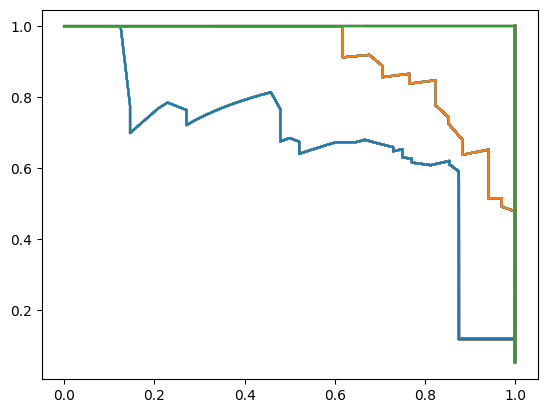

In [9]:
coco_gt = COCO('../info/test.json')
coco_pred = coco_gld.loadRes('../mmdetection/result/retinanet_swin-l/result.bbox.json')

cocoEval = COCOeval(coco_gt, coco_pred, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()

for catId in range(1,4):
    cat_list = []
    p_list = []
    r_list = []
    for conf in np.linspace(.0, 1, int(np.round((1.00 - .0) / .01)) + 1, endpoint=False) :
        try:
            p , r = get_PR(coco_gt  , cocoEval, conf , catId=catId)
            p_list.append(p)
            r_list.append(r)
            cat_list.append(catId)
        except:
            p_list.append(1)
            r_list.append(0)
            cat_list.append(catId)
        plt.plot(r_list , p_list)